In [1]:
from numba import cuda, jit, int64
import numpy as np
import timeit, random, time
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

In [2]:
sharpen_matrix = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

blur_matrix = np.array([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
])

outline_matrix = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])

In [3]:
def calculate_target_size(img_size, kernel_size):
    width = img_size[0] - kernel_size[0] + 1
    height = img_size[1] - kernel_size[1] + 1
    return (width, height)

In [4]:
def gpu_convolve_runner(img, kernel):
    # Generate the output array like before
    tgt_size = calculate_target_size(
        img_size=img.shape,
        kernel_size=kernel.shape
    )
    convolved_img = np.zeros(shape=tgt_size)
    
    # The maximum number of threads per block is 1024, so the maximum would be 32 by 32. We use 16 by 16 here because why not :D
    blockDim = (16, 16)
    
    # This will determine the number of blocks needed and the dimension of the grid
    gridDim = (tgt_size[0] // blockDim[0] + 1, tgt_size[1] // blockDim[1] + 1)
    
    # Calling the GPU function. This will run the gpu_convolve function on every single thread in every block, and each thread will perform one singular convolution.
    gpu_convolve[gridDim, blockDim](np.array(img), kernel, convolved_img)
    
    return convolved_img
    

@cuda.jit
def gpu_convolve(image, mask, result):
    # cuda.gird(2) will return the absolute position of the thread in the entire grid. The 2 is the number of dimensions. Essentially, this is 
    # cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x but in a single function.
    i, j = cuda.grid(2)
    
    # If i or j are outside of the bounds, return. This is because the largest i and j will always be a multiple of 16 (the block dimensions)
    image_rows, image_cols = result.shape
    if (i >= image_rows) or (j >= image_cols): 
        return
    
    # Set initial sum to 0
    s = 0
    
    # Create the sub-array
    kx = mask.shape[0]
    ky = mask.shape[1]
    mat = image[i:i+kx, j:j+ky]
    
    # Calculate the sum
    for k in range(mat.shape[0]):
        for l in range(mat.shape[1]):
            s += mat[k, l] * mask[k, l]

    result[i, j] = max(0, s) # relu

In [5]:
from math import ceil
def gpu_maxpool_runner(img, dim):
    size_x = ceil(img.shape[0] / dim[0])
    size_y = ceil(img.shape[1] / dim[1])
    
    result = np.zeros(shape=(size_x, size_y))
    
    blockDim = (16, 16)
    gridDim = (size_x // blockDim[0] + 1, size_y // blockDim[1] + 1)
    
    gpu_maxpool[gridDim, blockDim](np.array(img), np.array(dim), result)
    
    return result

@cuda.jit
def gpu_maxpool(img, dim, res):
    i, j = cuda.grid(2)
        
    if (i >= res.shape[0]) or (j >= res.shape[1]): 
        return
        
    maxpool = -999
    
    for k in range(dim[0]):
        for l in range(dim[1]):
            if dim[0]*i+k < img.shape[0] and dim[1]*j+l < img.shape[1]:
                maxpool = max(img[dim[0]*i+k][dim[1]*j+l], maxpool)
            else:
                maxpool = max(0, maxpool)

    res[i][j] = maxpool

In [6]:
from tensorflow import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [7]:
x_train = x_train[0:10000]
y_train = y_train[0:10000]
x_test = x_test[0:2000]
y_test = y_test[0:2000]

In [8]:
def preprocess_pipeline(img):
    img = img.astype("float32") / 255.0
    img = gpu_convolve_runner(img, outline_matrix)
    img = gpu_maxpool_runner(img, (2, 2))
    img = gpu_convolve_runner(img, sharpen_matrix)
    img = gpu_maxpool_runner(img, (2, 2))
    return img

def flatten(img):
    img = np.reshape(img, 36)
    return img

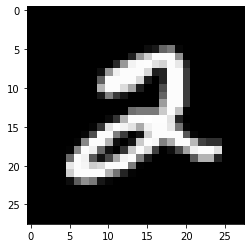

In [9]:
test_img = x_train[5]
plt.imshow(test_img, cmap = 'gray')

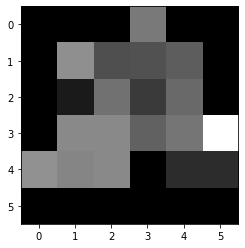

In [10]:
test_img_final = preprocess_pipeline(np.array(test_img))
plt.imshow(test_img_final, cmap="gray")

In [11]:
flatten(test_img_final)

array([ 0.        ,  0.        ,  0.        ,  8.94509769,  0.01960885,
        0.        ,  0.        , 10.58039154,  5.89019635,  6.02352937,
        6.86274488,  0.        ,  0.        ,  1.97647172,  8.43921534,
        4.28235292,  7.79215674,  0.        ,  0.        , 10.13333362,
       10.11764675,  7.26666635,  8.65882323, 18.87843148, 10.72941216,
        9.86274501, 10.14509797,  0.        ,  3.36862797,  3.28235334,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [12]:
x_train_processed = []
for x in x_train:
    new = flatten(preprocess_pipeline(x))
    x_train_processed.append(new)
x_train_processed = np.array(x_train_processed)

x_test_processed = []
for x in x_test:
    new = flatten(preprocess_pipeline(x))
    x_test_processed.append(new)
x_test_processed = np.array(x_test_processed)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

In [14]:
model = Sequential()
model.add(Dense(36, input_shape=(36,), activation="sigmoid"))
model.add(Dense(16, activation="relu"))
model.add(Dense(10, activation="softmax"))

y_train_category = to_categorical(y_train, 10)
y_test_category = to_categorical(y_test, 10)

In [15]:
sgd = SGD(0.1)
model.compile(loss="categorical_crossentropy", optimizer = "adam", metrics=["accuracy"])
H = model.fit(x_train_processed, y_train_category, epochs=100, batch_size=128)

Epoch 1/100
79/79 [==============================] - 8s 17ms/step - loss: 2.1890 - accuracy: 0.2364
Epoch 2/100
79/79 [==============================] - 1s 17ms/step - loss: 1.7426 - accuracy: 0.4768
Epoch 3/100
79/79 [==============================] - 1s 15ms/step - loss: 1.3044 - accuracy: 0.6307
Epoch 4/100
79/79 [==============================] - 1s 16ms/step - loss: 1.0514 - accuracy: 0.6974
Epoch 5/100
79/79 [==============================] - 1s 16ms/step - loss: 0.9189 - accuracy: 0.7278
Epoch 6/100
79/79 [==============================] - 1s 16ms/step - loss: 0.8422 - accuracy: 0.7452
Epoch 7/100
79/79 [==============================] - 1s 15ms/step - loss: 0.7953 - accuracy: 0.7544
Epoch 8/100
79/79 [==============================] - 1s 16ms/step - loss: 0.7622 - accuracy: 0.7624
Epoch 9/100
79/79 [==============================] - 1s 15ms/step - loss: 0.7368 - accuracy: 0.7694
Epoch 10/100
79/79 [==============================] - 1s 16ms/step - loss: 0.7157 - accuracy: 0.7782

In [16]:
model.evaluate(x_test_processed, y_test_category)

63/63 [==============================] - 1s 13ms/step - loss: 0.6708 - accuracy: 0.7945


[0.6707645654678345, 0.7944999933242798]